# Predicting Housing Prices with Advanced Regression

### A Kaggle Competition

### 📃 The Problem

The goal of this project it to predict the sales price for each house in the provided data.

[**Competition Link**](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

### 👩‍💻 The Approach

My initial approach will be to:
- Understand the data (*what variables are in the data set?*)
- Identify any missing, incomplete or invalid data
- Visualise the data to get an understanding of the relationship between variables
- Idenitfy the most appropriate model to use to solve the problem (*predicting housing prices*)
- Train selected model
- Evaluate and Improve Model where required
- Prepare a version for deployment



### 📚 Libraries

In [65]:
# file extraction
import os
# from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import joblib


# data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,MinMaxScaler


# visualisations
import matplotlib.pyplot as plt


# Modelling
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# reloading modules
from importlib import reload

Data appears normal and data is ready for feature extraction


### 📈 Modeling


My first assumptiuons is that the predictors in the data is linear with the response variable (*sale price*)

My plan is to test linear regression & xgboost as potential models. I will also use principal componenet analysis to engineer the features most suitable for predicting housing prices.

In [61]:
# my custom functions
from transform_data import transform_clean_data, transform_clean_data_ohe, transform_clean_data_ohe_prod

model_results ={}

In [3]:

# load data
train_data = pd.read_csv('data/train.csv')

# clean dataset
train_data_cleaned, reference_dict =transform_clean_data(train_data)

# calculate log price 
train_data_cleaned['logPrice'] =np.log(train_data.SalePrice)

# assign predictor variable
y = train_data_cleaned.logPrice

# drop predictor columns
train_data_cleaned.drop(columns= ['logPrice','SalePrice'],inplace = True)

Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


In [4]:
# splitting into test & train set
X_train, X_test, y_train, y_test = train_test_split(train_data_cleaned, y, test_size=0.15, random_state=42)

# creating regression object and fitting data
regr = LinearRegression()
regr.fit(X_train, y_train)

predicted = regr.predict(X_test)

In [5]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predicted)
print(f"R-squared (R2) Score: {r2}")

model_results['Dummy regression']=(mse,r2)


Mean Squared Error: 0.01778810231728373
R-squared (R2) Score: 0.8903125108662457


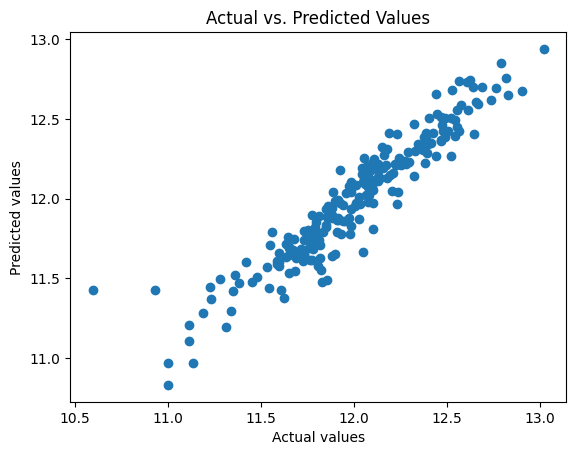

In [6]:
# plotting actual vs predicted
plt.scatter(y_test, predicted)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values")
plt.show()

the model seems to struggle with lower priced houses and could be improved

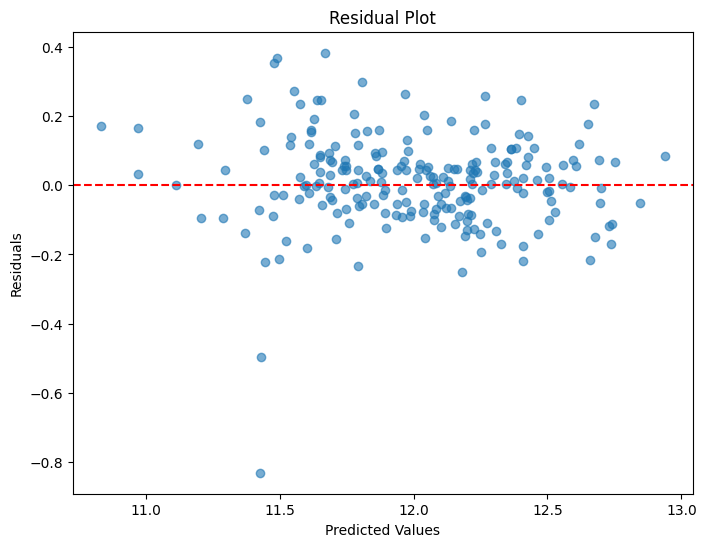

In [7]:
# Calculate residuals
residuals = [actual - predicted for actual, predicted in zip(y_test, predicted)]
# y_test, y_pred


# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(predicted, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

scatter plot of residuals dont appear to follow any type of distribution

### Applying Principal Componenet Analysis

Now we want to try and get the features that are most useful for regression

In [8]:
# load data
train_data = pd.read_csv('data/train.csv')

# clean dataset
train_data_cleaned, reference_dict =transform_clean_data(train_data)

# calculate log price 
train_data_cleaned['logPrice'] =np.log(train_data.SalePrice)

# assign predictor variable
y = train_data_cleaned.logPrice

# drop predictor columns
train_data_cleaned.drop(columns= ['logPrice','SalePrice'],inplace = True)

Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


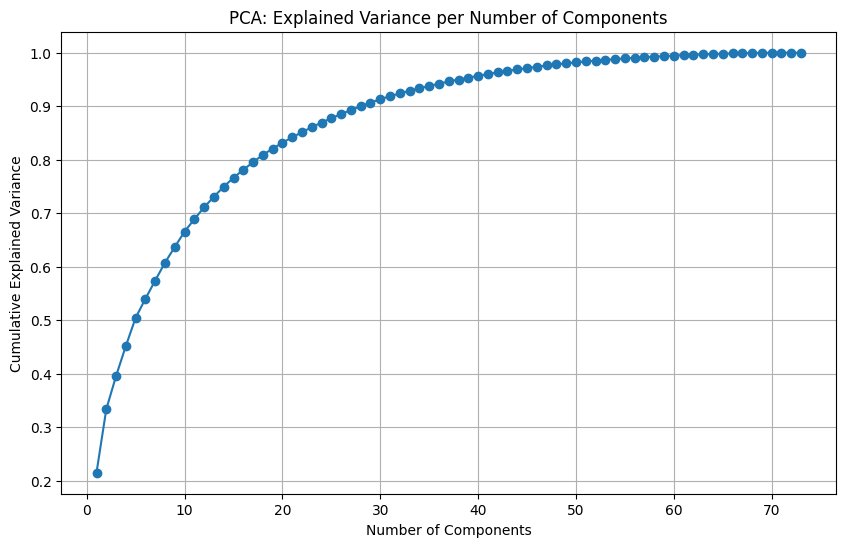

In [9]:
pca = PCA()

# Fit PCA on your data
pca.fit(train_data_cleaned)

# Calculate explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = explained_variance.cumsum()

# Plotting cumulative explained variance against number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance per Number of Components')
plt.grid(True)
plt.show()

In [10]:
performance ={}
for n in range(2,len(train_data_cleaned.columns)+1):
    
    # Apply PCA for dimensionality reduction
    pca =PCA(n_components=n)
    X_pca = pca.fit_transform(train_data_cleaned)

    # split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # perform linear regression

    regr = LinearRegression()
    regr.fit(X_train, y_train)

    # make predictions:
    y_pred = regr.predict(X_test)

    # evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    loadings =pd.DataFrame(pca.components_.T,columns = ["PC"+str(x) for x in range(1,n+1)],index=train_data_cleaned.columns.tolist())
    
    # add performance to list
    performance[n] =[mse,r2,loadings]

In [11]:
components = performance.keys()
mse_values = [result[0] for result in performance.values()]
r2_values = [result[1] for result in performance.values()]

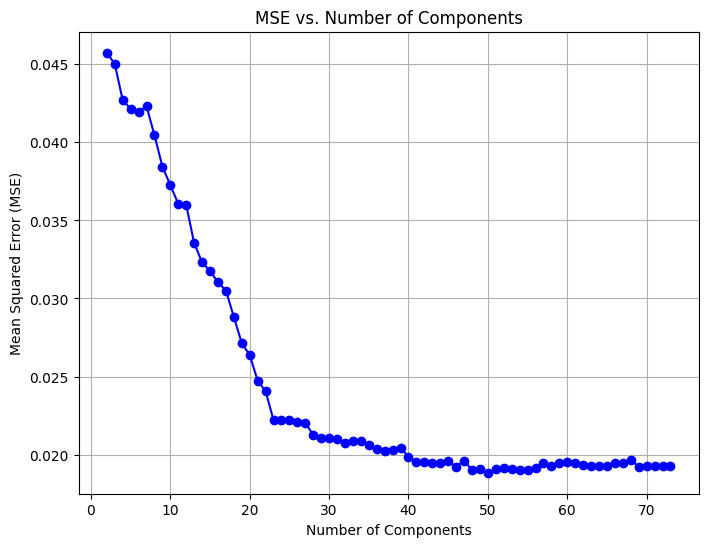

In [12]:
# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(components, mse_values, marker='o', linestyle='-', color='b')
plt.title('MSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

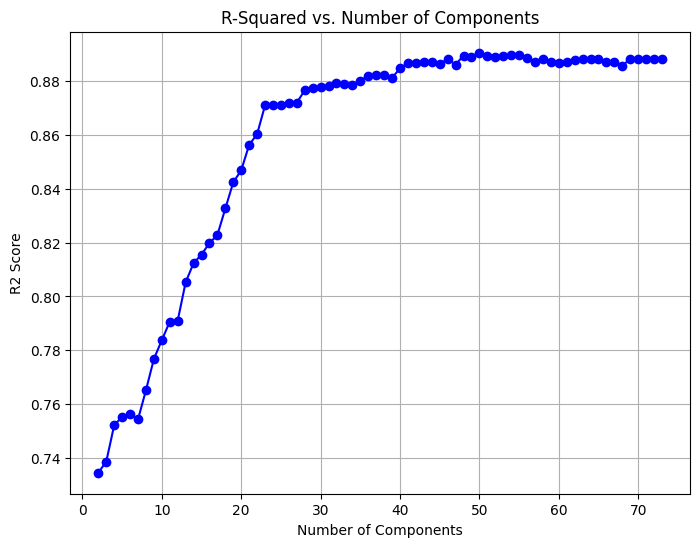

In [13]:
# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(components, r2_values, marker='o', linestyle='-', color='b')
plt.title('R-Squared vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

In [14]:
lowest_mse=1
pca_n_mse=""
highest_r2 =0
pca_n_r2=""

for k,tup in performance.items():
    if tup[0] < lowest_mse:
        lowest_mse = tup[0]
        pca_n_mse = k
    
    if tup[1] > highest_r2:
        highest_r2=tup[1]
        pca_n_r2 = k

In [15]:
print(f"The highest r-squared performance is {highest_r2} with {pca_n_r2} componenets")
print(f"The lowest mean-square error is {lowest_mse} with {pca_n_mse} componenets")

model_results['Linear Regression Dummy PCA '] = [lowest_mse,highest_r2,pca_n_r2]

The highest r-squared performance is 0.8906357786396095 with 50 componenets
The lowest mean-square error is 0.01883767949781597 with 50 componenets


In [16]:
 # Apply PCA for dimensionality reduction
pca =PCA(n_components=pca_n_mse)
X_pca = pca.fit_transform(train_data_cleaned)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# perform linear regression

regr = LinearRegression()
regr.fit(X_train, y_train)

# make predictions:
y_pred = regr.predict(X_test)

# evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

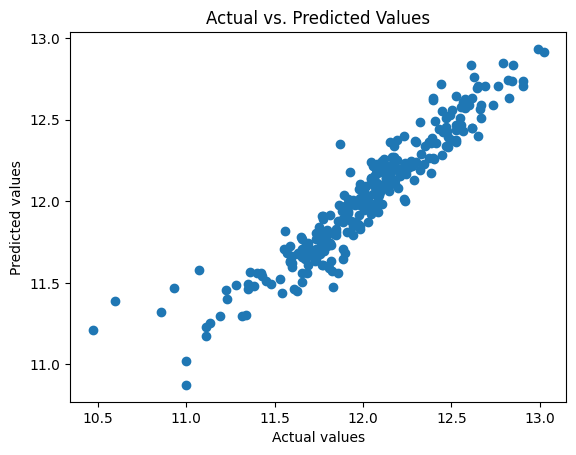

In [17]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values")
plt.show()

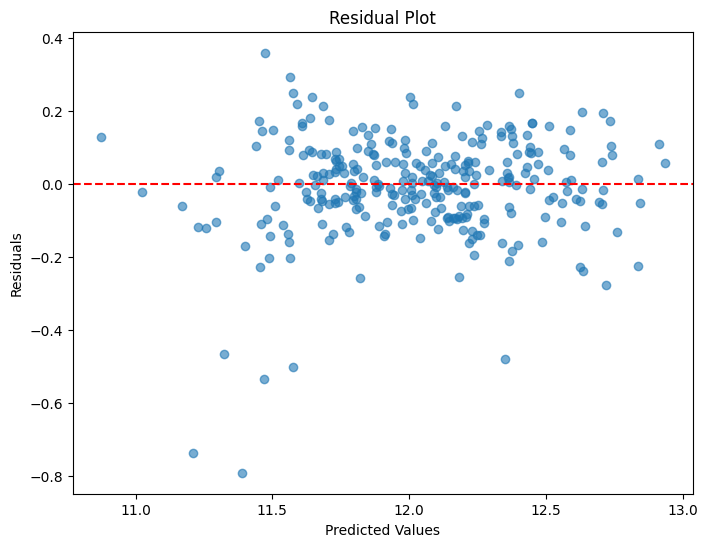

In [18]:
# Calculate residuals
residuals = [actual - predicted for actual, predicted in zip(y_test, y_pred)]
# y_test, y_pred
# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [19]:
model_results

{'Dummy regression': (0.01778810231728373, 0.8903125108662457),
 'Linear Regression Dummy PCA ': [0.01883767949781597, 0.8906357786396095, 50]}

it appears the PCa actually provided a greater mean square error for a small increase in an r2 score.

### Changing approach to use one hot encoding

``` for col in cat_col:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
    ohe_df =ohe.fit_transform(train_data[[cat_col[0]]])

    # Remove last column
    remove_col =ohe_df.columns[-1]
    reference_dict[col] = "ohe_"+str(remove_col)
    ohe_df = ohe_df.drop(columns=[remove_col])

    train_data= pd.concat([train_data,ohe_df], axis =1).drop(columns=[col])
```


In [20]:
# load data
train_data = pd.read_csv('data/train.csv')

# clean dataset
train_data_cleaned, reference_dict =transform_clean_data_ohe(train_data)

# calculate log price 
train_data_cleaned['logPrice'] =np.log(train_data.SalePrice)

# assign predictor variable
y = train_data_cleaned.logPrice

# drop predictor columns
train_data_cleaned.drop(columns= ['logPrice','SalePrice'],inplace = True)

Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


In [21]:
# splitting into test & train set
X_train, X_test, y_train, y_test = train_test_split(train_data_cleaned, y, test_size=0.15, random_state=42)

# creating regression object and fitting data
regr = LinearRegression()
regr.fit(X_train, y_train)

predicted = regr.predict(X_test)

In [22]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared (R2) score
r2 = r2_score(y_test, predicted)
print(f"R-squared (R2) Score: {r2}")

Mean Squared Error: 3.2078051544763224e+19
R-squared (R2) Score: -1.9780417649326378e+20


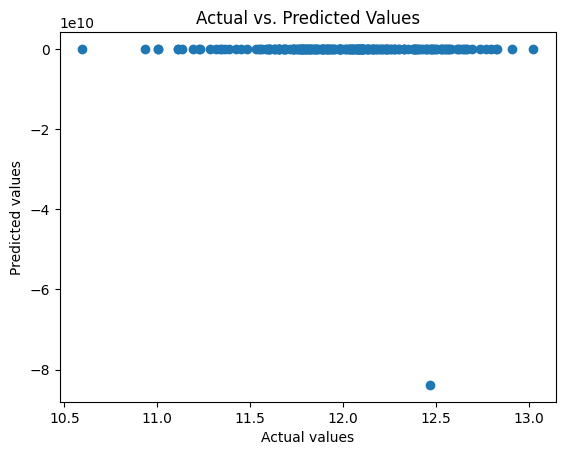

In [23]:
plt.scatter(y_test, predicted)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values")
plt.show()

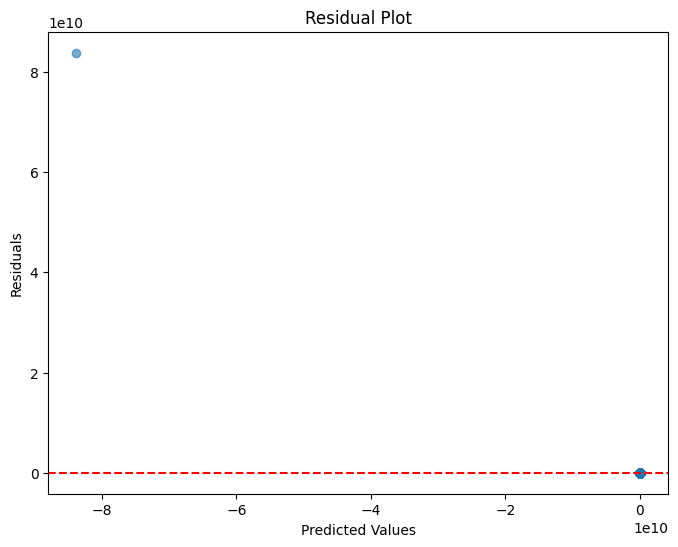

In [24]:
# Calculate residuals
residuals = [actual - predicted for actual, predicted in zip(y_test, predicted)]
# y_test, y_pred
# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(predicted, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [25]:
performance ={}
for n in range(2,len(train_data_cleaned.columns)+1):
    
    # Apply PCA for dimensionality reduction
    pca =PCA(n_components=n)
    X_pca = pca.fit_transform(train_data_cleaned)

    # split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # perform linear regression

    regr = LinearRegression()
    regr.fit(X_train, y_train)

    # make predictions:
    y_pred = regr.predict(X_test)

    # evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    loadings =pd.DataFrame(pca.components_.T,columns = ["PC"+str(x) for x in range(1,n+1)],index=train_data_cleaned.columns.tolist())
    
    # add performance to list
    performance[n] =[mse,r2,loadings]

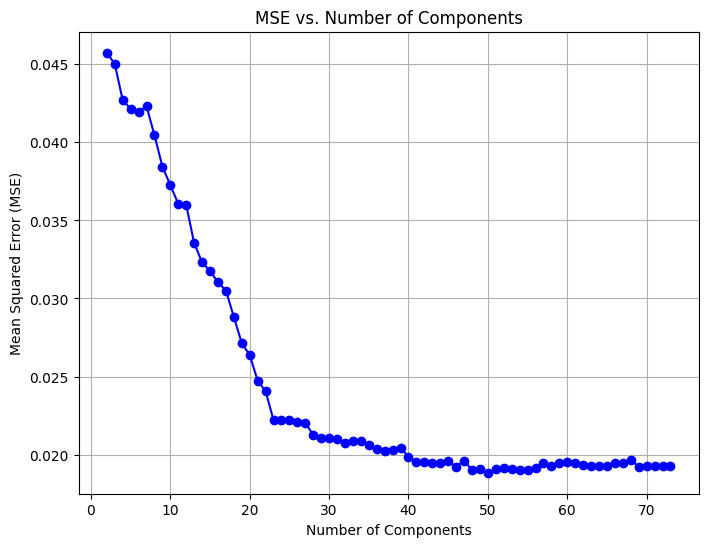

In [26]:
# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(components, mse_values, marker='o', linestyle='-', color='b')
plt.title('MSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

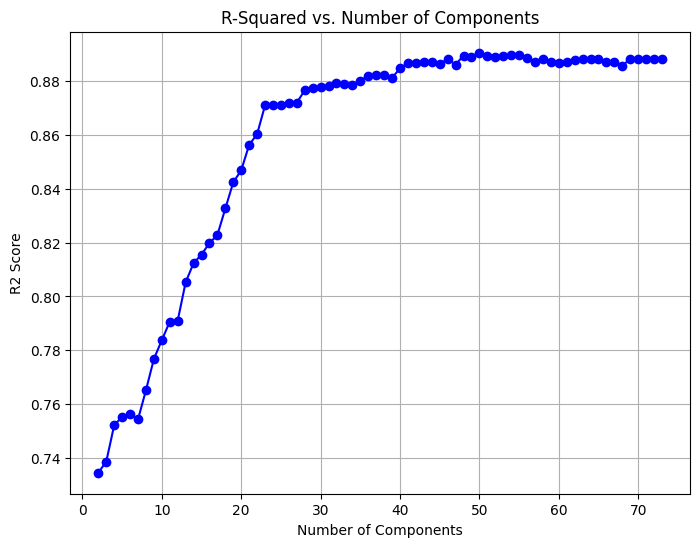

In [27]:
# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(components, r2_values, marker='o', linestyle='-', color='b')
plt.title('R-Squared vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

In [28]:
components = performance.keys()
mse_values = [result[0] for result in performance.values()]
r2_values = [result[1] for result in performance.values()]

In [29]:
lowest_mse=1
pca_n_mse=""
highest_r2 =0
pca_n_r2=""

for k,tup in performance.items():
    if tup[0] < lowest_mse:
        lowest_mse = tup[0]
        pca_n_mse = k
    
    if tup[1] > highest_r2:
        highest_r2=tup[1]
        pca_n_r2 = k

In [30]:
print(f"The highest r-squared performance is {highest_r2} with {pca_n_r2} componenets")
print(f"The lowest mean-square error is {lowest_mse} with {pca_n_mse} componenets")

model_results['Linear Reg OHE PCA'] = [lowest_mse,highest_r2,pca_n_mse]

The highest r-squared performance is 0.9083869535810087 with 155 componenets
The lowest mean-square error is 0.015780089546584896 with 155 componenets


In [31]:
 # Apply PCA for dimensionality reduction
pca =PCA(n_components=pca_n_mse)
X_pca = pca.fit_transform(train_data_cleaned)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# perform linear regression

regr = LinearRegression()
regr.fit(X_train, y_train)

# make predictions:
y_pred = regr.predict(X_test)

# evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

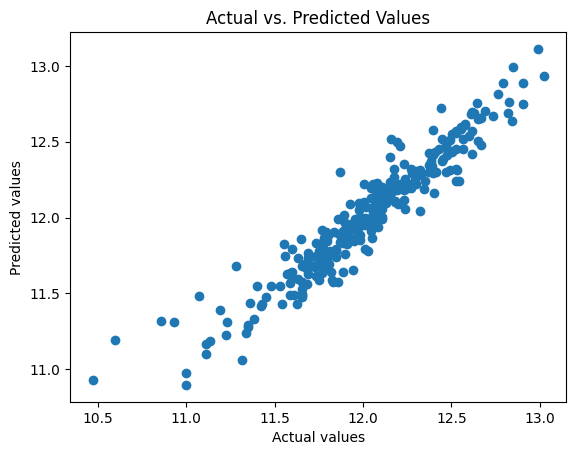

In [32]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values")
plt.show()

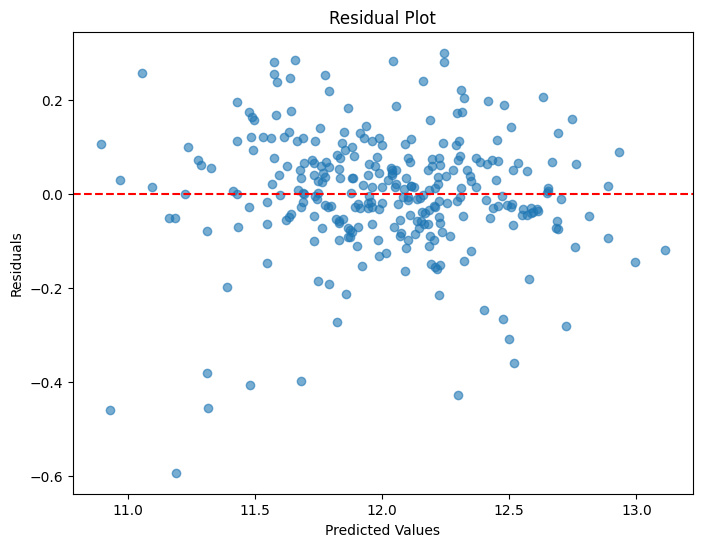

In [33]:
# Calculate residuals
residuals = [actual - predicted for actual, predicted in zip(y_test, y_pred)]
# y_test, y_pred
# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [34]:
model_results

{'Dummy regression': (0.01778810231728373, 0.8903125108662457),
 'Linear Regression Dummy PCA ': [0.01883767949781597, 0.8906357786396095, 50],
 'Linear Reg OHE PCA': [0.015780089546584896, 0.9083869535810087, 155]}

This has been the best model so far, residual plot follows no distribution and has yielded the best results so far

### Using XGBoost

In [35]:
train_data = pd.read_csv('data/train.csv')

train_data_cleaned, reference_dict =transform_clean_data_ohe(train_data)

train_data_cleaned['logPrice'] =np.log(train_data.SalePrice)

y = train_data_cleaned.logPrice
train_data_cleaned.drop(columns= ['logPrice','SalePrice'],inplace = True)

Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_data_cleaned, y, test_size=0.15, random_state=42)

In [37]:
# create instance of xgbregressor
xg_model = XGBRegressor()

# list of parameters to test
parameters={
    'learning_rate': [0.1, 0.01, 0.001, 0.3, 0.05, 0.2],
    'max_depth': [3, 5, 7,9,11],
    'n_estimators': [100, 250, 500 ,750, 1000]
    ,'reg_lambda' :[0,0.5,1,1.5,2,2.5]
    ,'reg_alpha': [0, 0.1, 0.5, 1, 5, 10]
    ,'gamma': [0, 0.1, 0.2, 0.5, 1, 2]
}

# create random search space to find optimal model- cannot use grid search as this is too many parameters

random_search = RandomizedSearchCV(estimator=xg_model, param_distributions=parameters, scoring='neg_mean_absolute_error', cv=8, verbose=1, n_iter = 1000, n_jobs =-1)

random_search.fit(X_train, y_train)

Fitting 8 folds for each of 1000 candidates, totalling 8000 fits


RandomizedSearchCV(cv=8,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2, 0.5, 1, 2],
                                        'learning_rate': [0.1, 0.01, 0.001, 0.3,
                                                          0.05, 0.2],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
                                        'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [38]:
best_xg_reg = random_search.best_estimator_
y_pred = best_xg_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Best Mean Squared Error on test set: ", mse)

r2 = r2_score(y_test, y_pred)
print("Best R2 on test set: ", r2)

model_results['XGboost'] =(mse,r2)

Best Mean Squared Error on test set:  0.01467990743523476
Best R2 on test set:  0.9094786976954655


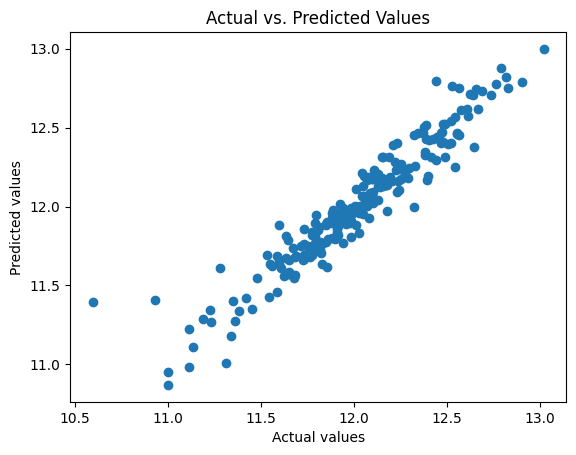

In [39]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values")
plt.show()

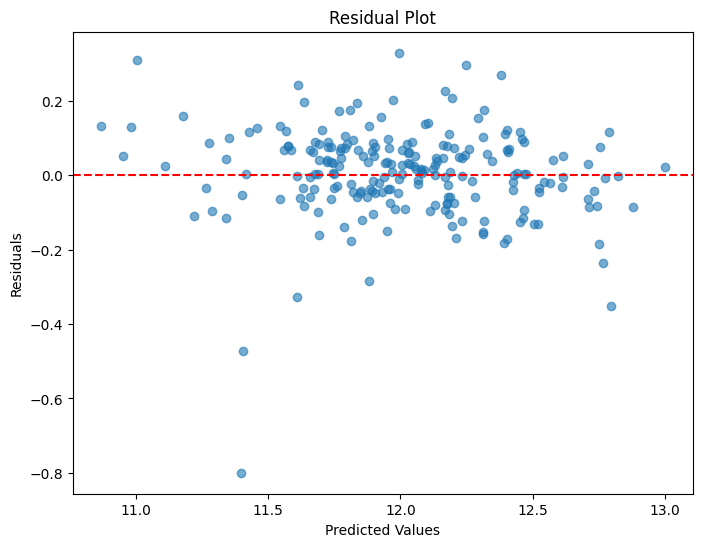

In [40]:
# Calculate residuals
residuals = [actual - predicted for actual, predicted in zip(y_test, y_pred)]
# y_test, y_pred
# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [41]:
random_search.best_params_

{'reg_lambda': 0.5,
 'reg_alpha': 0.1,
 'n_estimators': 500,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0}

residuals dont appear to follow any distribution this so far appears to be the best model, i will try and use PCA with XGBoost to see if we can get any better results

In [42]:
parameters=random_search.best_params_

# xg_model = XGBRegressor(**parameters)


train_data = pd.read_csv('data/train.csv')

train_data_cleaned, reference_dict =transform_clean_data_ohe(train_data)

train_data_cleaned['logPrice'] =np.log(train_data.SalePrice)

y = train_data_cleaned.logPrice
train_data_cleaned.drop(columns= ['logPrice','SalePrice'],inplace = True)

Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


In [43]:
# parameters ={'reg_lambda': 0.5,
#  'reg_alpha': 0.1,
#  'n_estimators': 1000,
#  'max_depth': 3,
#  'learning_rate': 0.05,
#  'gamma': 0}

parameters = random_search.best_params_

In [44]:
performance ={}
for n in range(2,len(train_data_cleaned.columns)+1):
    
    # Apply PCA for dimensionality reduction
    pca =PCA(n_components=n)
    X_pca = pca.fit_transform(train_data_cleaned)

    # split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # perform linear regression

    xg_model = XGBRegressor(**parameters)
    xg_model.fit(X_train, y_train)

    # make predictions:
    y_pred = xg_model.predict(X_test)

    # evaluate performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    loadings =pd.DataFrame(pca.components_.T,columns = ["PC"+str(x) for x in range(1,n+1)],index=train_data_cleaned.columns.tolist())
    
    # add performance to list
    performance[n] =[mse,r2,loadings]

In [45]:
components = performance.keys()
mse_values = [result[0] for result in performance.values()]
r2_values = [result[1] for result in performance.values()]

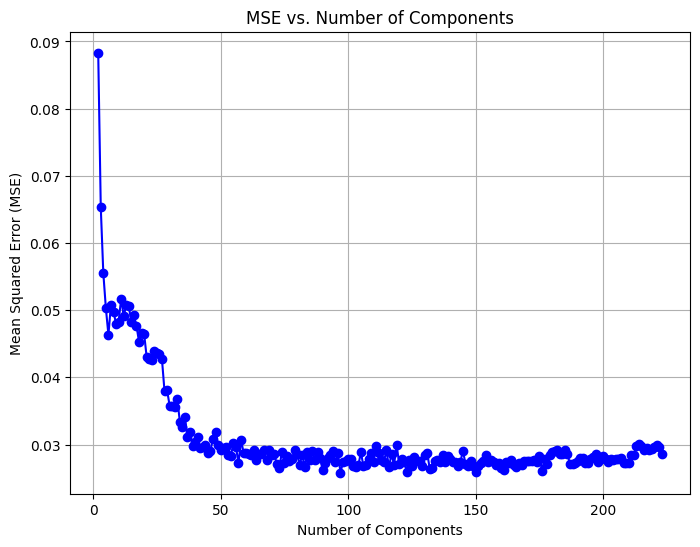

In [46]:
# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(components, mse_values, marker='o', linestyle='-', color='b')
plt.title('MSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

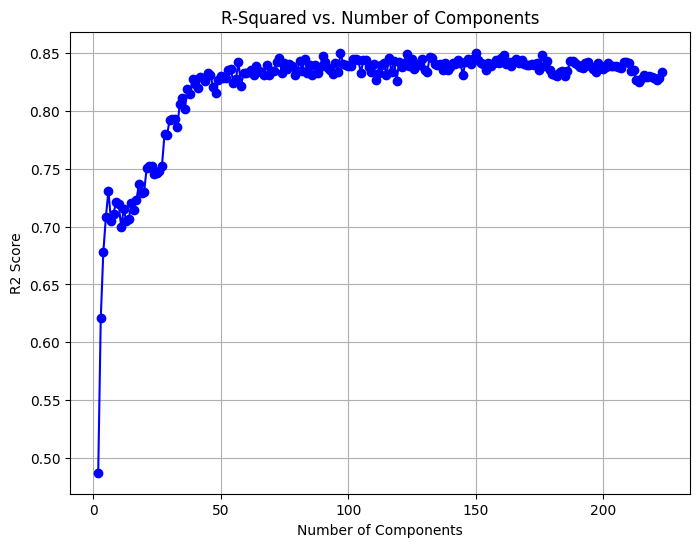

In [47]:
# Create a line graph
plt.figure(figsize=(8, 6))
plt.plot(components, r2_values, marker='o', linestyle='-', color='b')
plt.title('R-Squared vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

In [48]:
lowest_mse=1
pca_n_mse=""
highest_r2 =0
pca_n_r2=""

for k,tup in performance.items():
    if tup[0] < lowest_mse:
        lowest_mse = tup[0]
        pca_n_mse = k
    
    if tup[1] > highest_r2:
        highest_r2=tup[1]
        pca_n_r2 = k

In [49]:
print(f"The highest r-squared performance is {highest_r2} with {pca_n_r2} componenets")
print(f"The lowest mean-square error is {lowest_mse} with {pca_n_mse} componenets")

model_results['XGboost PCA'] = [lowest_mse,highest_r2,pca_n_mse]

The highest r-squared performance is 0.8501811853901697 with 97 componenets
The lowest mean-square error is 0.025805869389976272 with 97 componenets


In [50]:
 # Apply PCA for dimensionality reduction
pca =PCA(n_components=pca_n_mse)
X_pca = pca.fit_transform(train_data_cleaned)

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# perform xgboost regression

xg_model = XGBRegressor(**parameters)
xg_model.fit(X_train, y_train)

# make predictions:
y_pred = xg_model.predict(X_test)

# evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

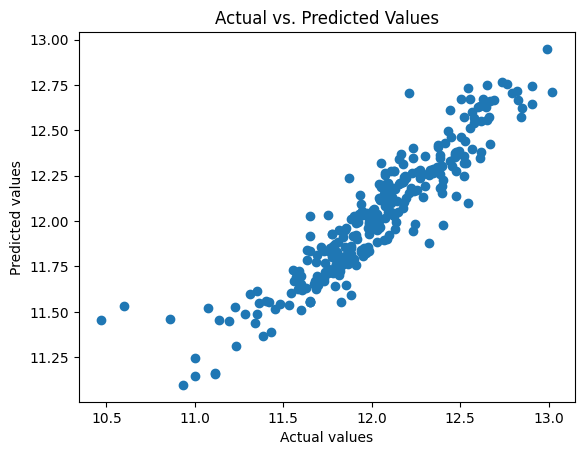

In [51]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs. Predicted Values")
plt.show()

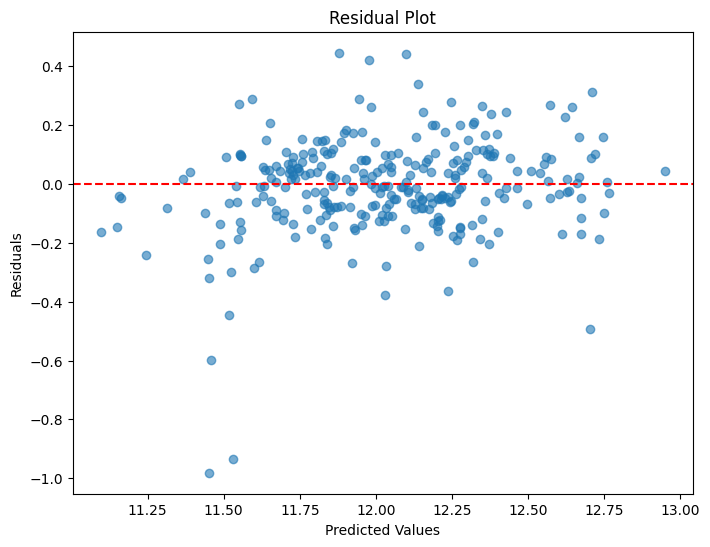

In [52]:
# Calculate residuals
residuals = [actual - predicted for actual, predicted in zip(y_test, y_pred)]
# y_test, y_pred
# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

It appears the best model is the inital xgboost model with a MSE of 0.01439 and r2 of 0.91124

In [53]:
# creating final model for saving

# parameters
# parameters ={'reg_lambda': 0.5,
#  'reg_alpha': 0.1,
#  'n_estimators': 1000,
#  'max_depth': 3,
#  'learning_rate': 0.05,
#  'gamma': 0}

train_data = pd.read_csv('data/train.csv')

train_data_cleaned, reference_dict =transform_clean_data_ohe(train_data)

train_data_cleaned['logPrice'] =np.log(train_data.SalePrice)

y = train_data_cleaned.logPrice
train_data_cleaned.drop(columns= ['logPrice','SalePrice'],inplace = True)



# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.01, random_state=42)

# perform linear regression

xg_model = XGBRegressor(**parameters)
xg_model.fit(train_data_cleaned, y)


Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
# Save the model to a file
model_file = 'optimal_model.pkl'
joblib.dump(xg_model, model_file)

['optimal_model.pkl']

In [55]:
model_results

{'Dummy regression': (0.01778810231728373, 0.8903125108662457),
 'Linear Regression Dummy PCA ': [0.01883767949781597, 0.8906357786396095, 50],
 'Linear Reg OHE PCA': [0.015780089546584896, 0.9083869535810087, 155],
 'XGboost': (0.01467990743523476, 0.9094786976954655),
 'XGboost PCA': [0.025805869389976272, 0.8501811853901697, 97]}

### 🚚 Submission|

In [76]:
# load data
test_data = pd.read_csv('data/test.csv')
print(test_data.shape)
# clean dataset
test_data_cleaned, reference_dict =transform_clean_data_ohe_prod(test_data)

(1459, 80)
Identifying null columns
Dropped these columns  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Filling NaN Values
Dropping NaN Rows
Normalise numerical data
encoding categorical data
finished encoding variables and processing data


In [77]:
print(test_data_cleaned.shape)
print(train_data_cleaned.shape)

(1459, 209)
(1459, 223)


In [78]:
# now to ensure data is in the same shape
missing_categories = set(test_data_cleaned.columns) - set(train_data_cleaned.columns)

# dropping missing from triaining set
test_data_cleaned = test_data_cleaned.drop(columns=missing_categories)

# finding missing from test set
missing_categories = set(train_data_cleaned.columns) - set(test_data_cleaned.columns)

# setting columns to 0
for col in missing_categories:
    test_data_cleaned[col] =0

# re-ordering columns
test_data_cleaned = test_data_cleaned[train_data_cleaned.columns]


# check data is correct shape
print(test_data_cleaned.shape)
print(train_data_cleaned.shape)

(1459, 223)
(1459, 223)


In [79]:
predictions =xg_model.predict(test_data_cleaned)
# output_df = pd.DataFrame(columns =['Id','SalePrice'])
output =[]


In [80]:
for id,val in zip(test_data['Id'].tolist(), predictions):
    new_rec ={'Id':id,'SalePrice':np.exp(val)}
    output.append(new_rec)

In [81]:
output_df = pd.DataFrame(output)

In [82]:
output_df.to_csv('submission.csv',index=False)